<a href="https://colab.research.google.com/github/NAVEED261/MY-AI-ASSISTANT/blob/main/Financial_Analysis_AI_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
%%capture --no-stderr
!pip install --upgrade langchain langchain_google_genai langgraph


In [85]:
import os
from google.colab import userdata

# Fetch API keys from Notebook secrets
GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')  # Google Gemini API key
LANGCHAIN_API_KEY = userdata.get('LANGCHAIN_API_KEY')  # LangSmith API key

# Configure environment variables for LangChain and LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"  # Enable LangSmith tracing
os.environ["LANGCHAIN_PROJECT"] = "memory-enabled-agent"  # Set LangSmith project name
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY  # Set LangSmith API key


In [86]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    api_key=GEMINI_API_KEY
)


In [87]:
def calculate_interest(principal: float, rate: float, time: float) -> float:
    """
    Calculates simple interest.
    """
    return (principal * rate * time) / 100

def calculate_profit(cost: float, revenue: float) -> float:
    """
    Calculates profit.
    """
    return revenue - cost

def compound_interest(principal: float, rate: float, time: float) -> float:
    """
    Calculates compound interest.
    """
    return principal * (1 + rate/100) ** time

financial_tools = [calculate_interest, calculate_profit, compound_interest]
llm_with_tools = llm.bind_tools(financial_tools)


In [88]:
llm_with_tools = llm.bind_tools(financial_tools)


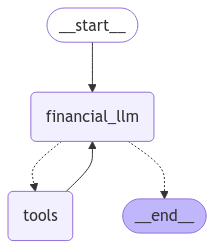

In [89]:
from langgraph.graph import START, END , StateGraph, MessagesState
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph
from langgraph.checkpoint.memory import MemorySaver
memory: MemorySaver = MemorySaver()

# Define LLM function for the graph
def financial_llm(state: MessagesState) -> MessagesState:
  # ek assistant bnaya jis ki state ma sub record moujod ha uski type msgstate ha jo state k under tmam msg ki state ha
   return {"messages": [llm_with_tools.invoke( state["messages"])]}


# Build the graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("financial_llm", financial_llm)
builder.add_node("tools", ToolNode(financial_tools))

builder.add_edge(START, "financial_llm")
builder.add_conditional_edges("financial_llm", tools_condition)
builder.add_edge("tools", "financial_llm")

# Compile the graph
graph: CompiledStateGraph = builder.compile(checkpointer=memory)

# Display graph
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [90]:
from langchain.schema import HumanMessage

# Configuration for the test
config1 = {"configurable": {"thread_id": "finance1"}}

In [91]:
messages = graph.invoke({"messages": [HumanMessage(content="Calculate simple interest for principal 10000, rate 5, and time 2 years.")]},config1)
for m in messages['messages']:
    m.pretty_print()



================================ Human Message =================================

Calculate simple interest for principal 10000, rate 5, and time 2 years.
================================== Ai Message ==================================
Tool Calls:
  calculate_interest (7272a73a-3e21-4a93-a731-72417807f4bf)
 Call ID: 7272a73a-3e21-4a93-a731-72417807f4bf
  Args:
    principal: 10000.0
    rate: 5.0
    time: 2.0
================================= Tool Message =================================
Name: calculate_interest

1000.0
================================== Ai Message ==================================

Simple interest is 1000.


In [92]:
messages = graph.invoke({"messages": [HumanMessage(content="Calculate compound interest for principal 15000, rate 7%, and time 3 years..")]},config1)
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

Calculate simple interest for principal 10000, rate 5, and time 2 years.
================================== Ai Message ==================================
Tool Calls:
  calculate_interest (7272a73a-3e21-4a93-a731-72417807f4bf)
 Call ID: 7272a73a-3e21-4a93-a731-72417807f4bf
  Args:
    principal: 10000.0
    rate: 5.0
    time: 2.0
================================= Tool Message =================================
Name: calculate_interest

1000.0
================================== Ai Message ==================================

Simple interest is 1000.
================================ Human Message =================================

Calculate compound interest for principal 15000, rate 7%, and time 3 years..
================================== Ai Message ==================================
Tool Calls:
  compound_interest (2d4d1bc4-1ca4-4ac0-b0b0-1b07c40b5481)
 Call ID: 2d4d1bc4-1ca4-4ac0-b0b0-1b07c40b5481
  Args: